In [57]:
from astropy.table import Table
import numpy as np
from ltsfit.ltsfit import ltsfit
from matplotlib import pyplot as plt
import corner
from utils import fit_plane, find_scatter, run_pairing_simulation_from_data
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [58]:
# load the GGL data tables with different sky areas of lenses bu galaxy population is on 10 deg^2
sky_area = "1000.0"
GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG.fits", format='fits')


GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,0.5422921796601345,4.638217605137028,0.6266746233869349,172.21951293027246,156903128493.03488,24.6669106378357,24.977237252798375,26.65811555125584,24.75079767527197,24.5929497379952,20.646736721399538,21.56545134246853,22.902884025277903,20.2695901620304,20.03825775020813,0.6172205764231248,-0.09198968386593932,0.08281080930991648,0.12377290525926427,2,3.9295369783032505,3475.4568048872643,24.34411014642516
1,1.2658720734964457,3.2961176259300564,1.4130586192975143,345.3573885928963,941089039903.8513,27.64031152133942,27.730204310337086,27.998126861336814,27.55498640369833,27.492599282660997,22.381395685350615,23.33851107386904,23.812004807840733,21.723632312140854,20.990035947722202,1.2430642889883141,0.3569080725833705,0.03336339277947742,0.35846406828709365,2,10.382942795805155,5121.352500697216,26.8292051664958
2,0.9110935745097991,3.221779909568209,1.5846096603045727,321.9072122557094,891868914214.0876,26.522562679736076,26.59173100842414,26.76123187181134,26.45561475776632,26.447991527205176,21.06121604916761,22.094271843406606,23.52591429862971,20.18561366182644,19.846578596225104,0.5296223848913996,0.004926402937471986,0.18393120998778525,0.18399717240618965,2,4.140689395579168,11473.496991301821,24.62439326200261
3,1.8818214037750418,2.9143342271822967,0.9242424655821047,398.19935534487735,1359154142715.3452,27.6689201437216,27.80184299767997,27.877196059393732,27.583862324748907,27.61087336937149,23.76458139394629,23.853566902826703,23.97914969656124,23.19362861419547,22.74912448577685,1.76001078877406,0.020915561869467046,0.11229093707391442,0.11422221884227829,2,14.817720681945206,4930.960208273062,27.67058361579314
4,0.500715551154351,2.5076060982479436,0.9857173776100766,224.8562970003985,371723115173.6034,26.838230616584255,26.96505519338608,27.068450128023414,26.849919396045642,26.739519539869463,19.391751722550204,20.13999657427091,21.31041336097845,19.033830381572535,18.79100201616761,0.4720541651161308,0.14150631916602743,0.004236869975891904,0.1415697334570855,2,2.8837140723923977,8061.744066353982,22.15228932934869
5,1.1668144501081206,2.107867931513425,1.539157184536788,416.4059016332125,1560680291724.585,25.338923604825762,25.448868380103388,25.66022750914726,25.124032317007458,24.95433803628075,21.484380732083267,22.372972888737465,23.054850213918776,20.700405056823854,20.065230951003848,1.1072048744580938,-0.06946517696208823,-0.17564725380722074,0.1888845376953668,2,9.143117531171745,8689.545764953042,25.746348199661195
6,0.9268390891034295,2.595321831129954,0.8686480966261878,252.0576330963934,494848482196.93634,25.359289693756757,25.703177043474987,26.072876253458872,25.26419253094948,24.98196207468328,21.753237080114026,22.808775629337234,24.505792989742737,20.870291316093038,20.51389293225283,0.9036358588083453,-0.3569838109761175,-0.14003590021631493,0.3834677230855631,2,7.098370072222088,3969.349419852493,26.766457978168585
7,0.8550995953859445,3.4102894330325104,0.649379630093777,199.93952333773603,262134555138.39606,27.207161502873415,27.386059044408224,27.92343063244544,27.019034403772213,26.865366365326384,21.924322723543273,22.909672958619677,23.95823902603509,21.167835899998632,20.904167758454303,0.2851404257557659,-0.025713147565583433,-0.009751951209001,0.027500300182219925,2,2.187875779272772,8444.322349033686,23.701286749619943
8,0.19485490028664953,2.238716038643002,1.0126203859247265,202.6114851086831,273581387887.11835,26.4750644349338,26.625836320704913,26.892785217528704,26.280874678562377,25.993433911600874,17.113432502084997,17.586896030826793,18.6146131195011,16.852230306

In [59]:
# 1 year coadd
# point source depths: g < 26.0, r < 25.7, i < 25.0, z < 24.3, y < 23.1
# extended source depths are 1 mag shallower: g < 25.0, r < 24.7, i < 24.0, z < 23.3, y < 22.1
lsst_1_yr_coadd_mag_depth_mask = (
                        ((GGL_data_table['mag_D_g'] < 25.0) | 
                        (GGL_data_table['mag_D_r'] < 24.7) |
                        (GGL_data_table['mag_D_i'] < 24.0) |
                        (GGL_data_table['mag_D_z'] < 23.3) |
                        (GGL_data_table['mag_D_y'] < 22.1) )
                        
                        &

                        ((GGL_data_table['mag_S_g'] < 25.0) |
                        (GGL_data_table['mag_S_r'] < 24.7) |
                        (GGL_data_table['mag_S_i'] < 24.0) |
                        (GGL_data_table['mag_S_z'] < 23.3) |
                        (GGL_data_table['mag_S_y'] < 22.1))
)

# 10 year coadd
# point source depths: g < 27.4, r < 27.5, i < 26.8, z < 26.1, y < 24.9
# extended source depths are 1 mag shallower: g < 26.4, r < 26.5, i < 25.8, z < 25.1, y < 23.9
lsst_10_yr_coadd_mag_depth_mask = (
                        ((GGL_data_table['mag_D_g'] < 26.4) | 
                        (GGL_data_table['mag_D_r'] < 26.5) |
                        (GGL_data_table['mag_D_i'] < 25.8) |
                        (GGL_data_table['mag_D_z'] < 25.1) |
                        (GGL_data_table['mag_D_y'] < 23.9) )
                        
                        &

                        ((GGL_data_table['mag_S_g'] < 26.4) |
                        (GGL_data_table['mag_S_r'] < 26.5) |
                        (GGL_data_table['mag_S_i'] < 25.8) |
                        (GGL_data_table['mag_S_z'] < 25.1) |
                        (GGL_data_table['mag_S_y'] < 23.9) )
)

# 4MOST spec-z for sources: r < 23.5 and z < 1.5

lsst_4MOST_mag_depth_mask = (
                        (GGL_data_table['mag_D_r'] < 23.5) & (GGL_data_table['mag_S_r'] < 23.5) &
                        (GGL_data_table['z_S'] < 1.5) # 4MOST limit
)


lsst_1_yr_GGL_table = GGL_data_table[lsst_1_yr_coadd_mag_depth_mask]
lsst_10_yr_GGL_table = GGL_data_table[lsst_10_yr_coadd_mag_depth_mask]
lsst_4MOST_GGL_table = GGL_data_table[lsst_4MOST_mag_depth_mask]



print('----------------------------------')
print("Sky area:", sky_area, "deg^2")
print('----------------------------------')
print("Total (g < 28) # lenses:", len(GGL_data_table))
print("Y1  (g < 25.0 | r < 24.7 | i < 24.0)   # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask))
print("Y10 (g < 26.4 | r < 26.5 | i < 25.8)   # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask))
print("4MOST (r < 23.5 & z_S < 1.5)           # lenses:", np.sum(lsst_4MOST_mag_depth_mask))
print('----------------------------------')
print()
# print('----------------------------------')
# print("Sky area:", 20000, "deg^2")
# print('----------------------------------')
# print("Y1 # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask)*20000/float(sky_area))
# print("Y10 # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask)*20000/float(sky_area))
# print("4MOST # lenses:", np.sum(lsst_4MOST_mag_depth_mask)*20000/float(sky_area))
# print('----------------------------------')

_, idx_unique_deflectors = np.unique(lsst_1_yr_GGL_table['z_D'], return_index=True)
lsst_1_yr_GGL_table_unique_deflectors = lsst_1_yr_GGL_table[np.sort(idx_unique_deflectors)]
_, idx_unique_deflectors = np.unique(lsst_10_yr_GGL_table['z_D'], return_index=True)
lsst_10_yr_GGL_table_unique_deflectors = lsst_10_yr_GGL_table[np.sort(idx_unique_deflectors)]
_, idx_unique_deflectors = np.unique(lsst_4MOST_GGL_table['z_D'], return_index=True)
lsst_4MOST_GGL_table_unique_deflectors = lsst_4MOST_GGL_table[np.sort(idx_unique_deflectors)]


print('----------------------------------')
print("After removing repeated deflectors:")
print('----------------------------------')
print("Y1  (g < 25.0 | r < 24.7 | i < 24.0)   # lenses:", len(lsst_1_yr_GGL_table_unique_deflectors))
print("Y10 (g < 26.4 | r < 26.5 | i < 25.8)   # lenses:", len(lsst_10_yr_GGL_table_unique_deflectors))
print("4MOST (r < 23.5 & z_S < 1.5)           # lenses:", len(lsst_4MOST_GGL_table_unique_deflectors))
print('----------------------------------')
print()

----------------------------------
Sky area: 1000.0 deg^2
----------------------------------
Total (g < 28) # lenses: 98303
Y1  (g < 25.0 | r < 24.7 | i < 24.0)   # lenses: 11104
Y10 (g < 26.4 | r < 26.5 | i < 25.8)   # lenses: 53547
4MOST (r < 23.5 & z_S < 1.5)           # lenses: 471
----------------------------------

----------------------------------
After removing repeated deflectors:
----------------------------------
Y1  (g < 25.0 | r < 24.7 | i < 24.0)   # lenses: 7947
Y10 (g < 26.4 | r < 26.5 | i < 25.8)   # lenses: 23096
4MOST (r < 23.5 & z_S < 1.5)           # lenses: 432
----------------------------------



SLSim Lenses (1000.0 deg$^2$) Y1-like Depth sigma_v scatter (MFP): 0.46543325003363406 %
SLSim Lenses (1000.0 deg$^2$) Y10-like Depth sigma_v scatter (MFP): 0.48573542587822727 %
SLSim Lenses (1000.0 deg$^2$) 4MOST-like Depth sigma_v scatter (MFP): 0.4486548209166571 %


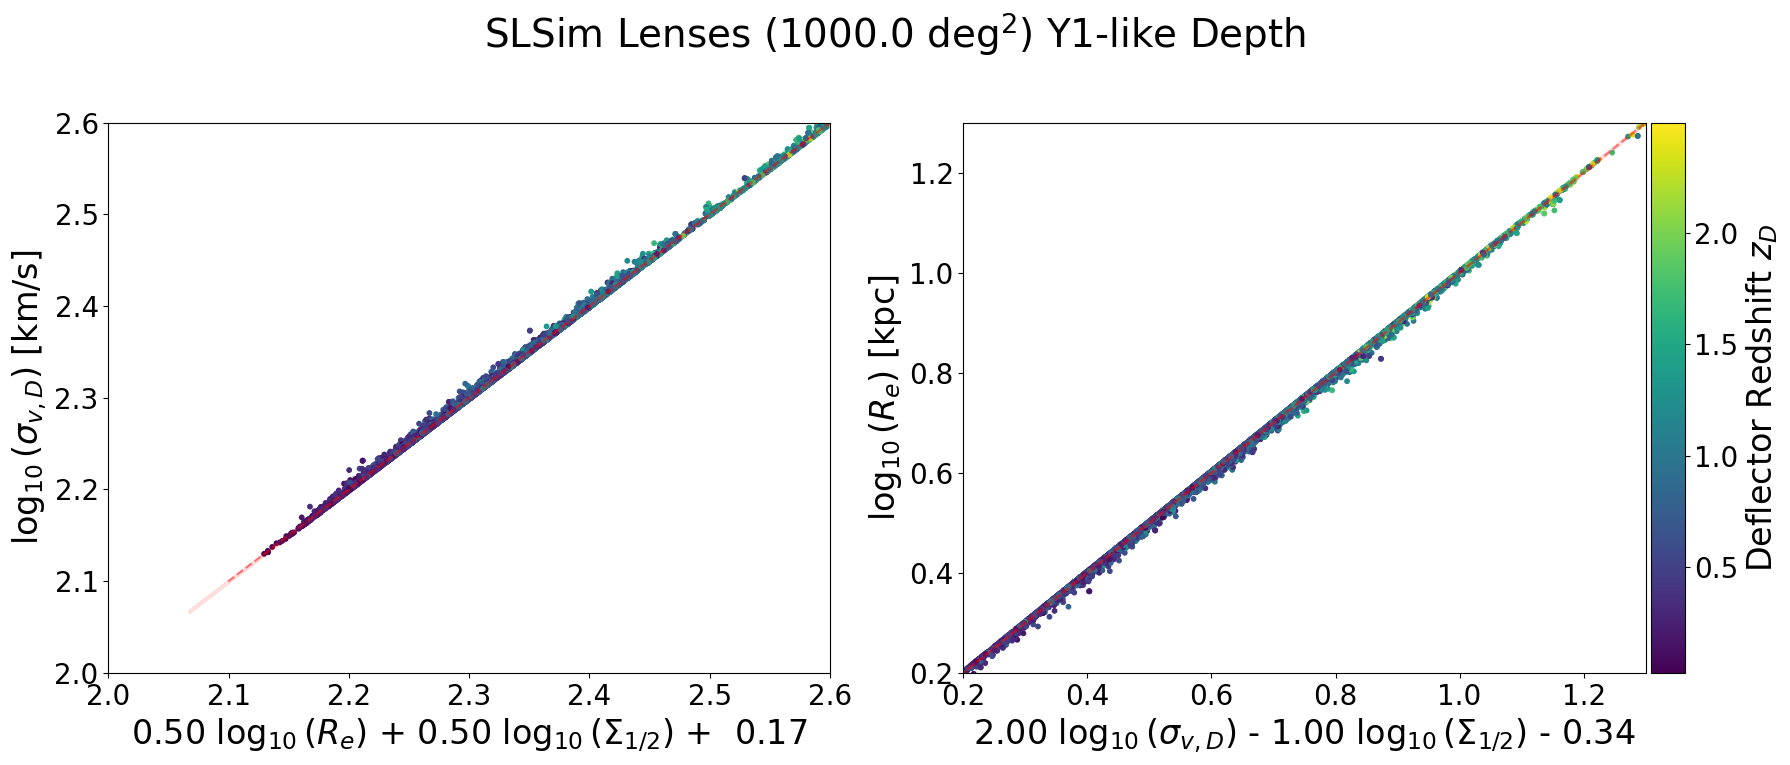

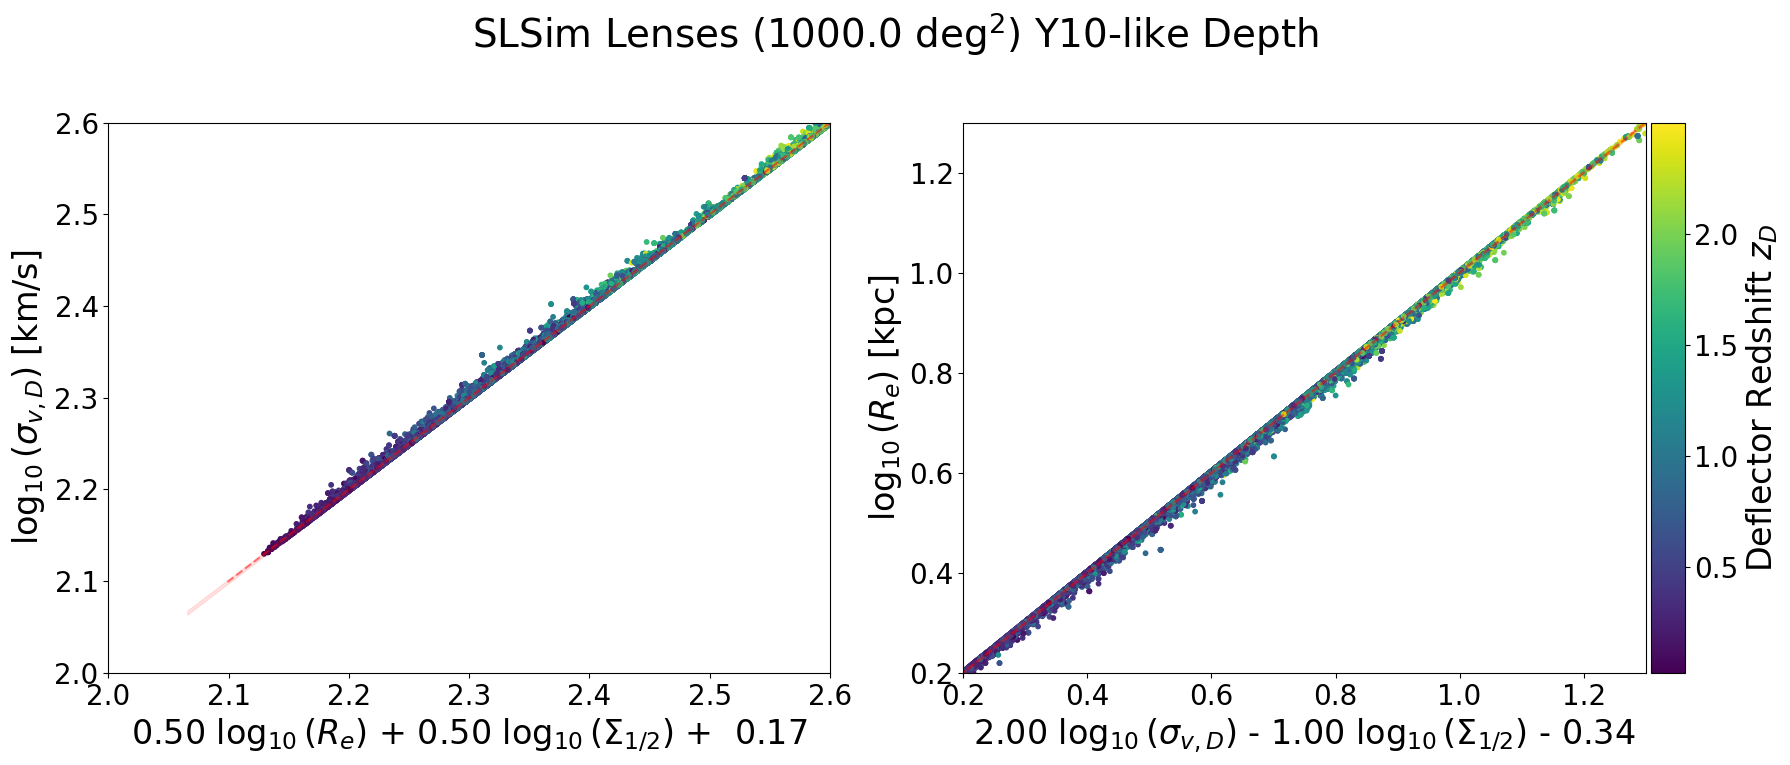

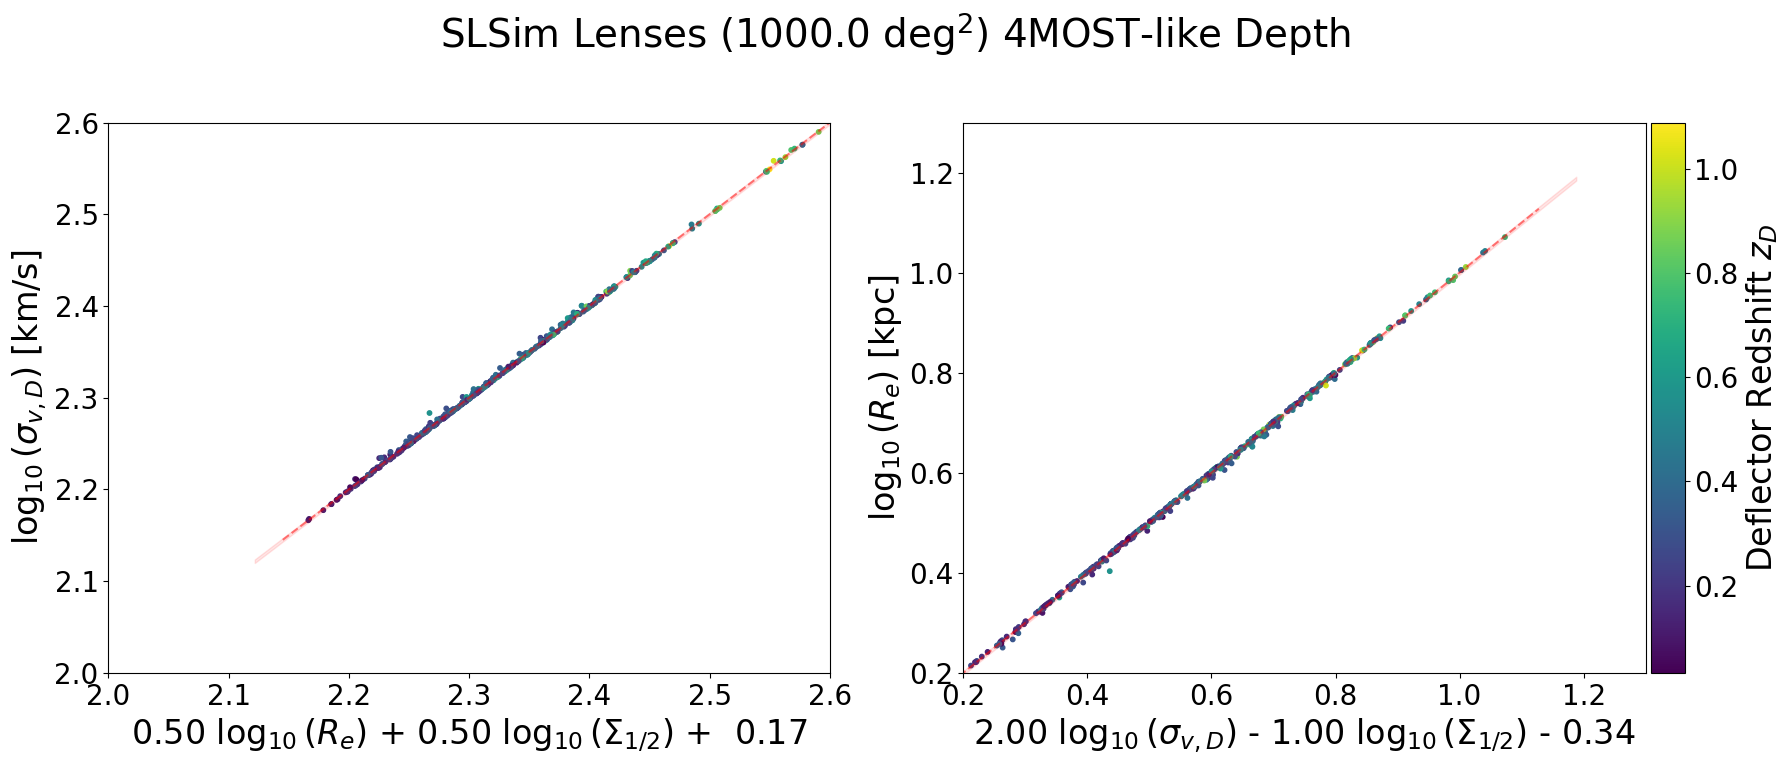

In [60]:
# MFP for the original data at different depths

title_list = [
    f"SLSim Lenses ({sky_area} deg$^2$) Y1-like Depth",
    f"SLSim Lenses ({sky_area} deg$^2$) Y10-like Depth",
    f"SLSim Lenses ({sky_area} deg$^2$) 4MOST-like Depth",
]
i = 0
for data_table in [GGL_data_table[lsst_1_yr_coadd_mag_depth_mask],
                   GGL_data_table[lsst_10_yr_coadd_mag_depth_mask],
                   GGL_data_table[lsst_4MOST_mag_depth_mask]]:
    # fit the MFP
    coeffs_MFP = fit_plane(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"])
    )

    # find the scatter
    scatter_MFP = find_scatter(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"]),
        coeffs_MFP,
        return_fit=False
    )

    # fit the MFP with R_e as the dependent variable
    coeffs_MFP_alt = fit_plane(
        np.log10(data_table["sigma_v_D"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["R_e_kpc"])
    )

    # find the scatter
    scatter_MFP_alt = find_scatter(
        np.log10(data_table["sigma_v_D"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["R_e_kpc"]),
        coeffs_MFP_alt,
        return_fit=False
    )

    # print the scatter in percentage
    print(title_list[i], "sigma_v scatter (MFP):", np.std(scatter_MFP) * np.log(10) * 100, "%")
    # print(title_list[i], "scatter (MFP alt):", np.std(scatter_MFP_alt) * np.log(10) * 100, "%")

    # side-by-side plot of the two fundamental planes
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # sigma_v fundamental plane
    axs[0].scatter(
        coeffs_MFP[0] * np.log10(data_table["R_e_kpc"]) + 
        coeffs_MFP[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP[2],
        np.log10(data_table["sigma_v_D"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[0].set_xlabel(f'{coeffs_MFP[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_MFP[1]:.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ + ' + f' {coeffs_MFP[2]:.2f}')
    axs[0].set_ylabel(r'$\log_{10}(\sigma_{v, D})$ [km/s]')
    # axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

    # Plot the fitted plane with a faded scatter
    # y = x
    axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
    y_faded = x_faded
    axs[0].fill_between(x_faded, y_faded - np.std(scatter_MFP),
                        y_faded + np.std(scatter_MFP), color='red', alpha=0.1)

    # R_e fundamental plane
    scatter_plot = axs[1].scatter(
        coeffs_MFP_alt[0] * np.log10(data_table["sigma_v_D"]) + 
        coeffs_MFP_alt[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP_alt[2],
        np.log10(data_table["R_e_kpc"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[1].set_xlabel(f'{coeffs_MFP_alt[0]:.2f} ' + r'$\log_{10}(\sigma_{v, D})$ ' + f'{'+' if coeffs_MFP_alt[1] > 0 else '-'} {np.abs(coeffs_MFP_alt[1]):.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ ' + f'{'+' if coeffs_MFP_alt[2] > 0 else '-'} {np.abs(coeffs_MFP_alt[2]):.2f}')
    axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
    # axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
    # Plot the fitted plane with a faded scatter
    # y = x
    axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
    y_faded = x_faded
    axs[1].fill_between(x_faded, y_faded - np.std(scatter_MFP_alt),
                        y_faded + np.std(scatter_MFP_alt), color='red', alpha=0.1)

    # common colorbar
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scatter_plot, cax=cax)
    cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


    # increase the font size of the labels and title
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24)
        ax.set_title(ax.get_title(), fontsize=24)
        # ax.legend(fontsize=14)

    # cbar label size
    cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=24)

    # cbar tick labels
    cbar.ax.tick_params(labelsize=20)

    axs[0].set_xlim(2, 2.6)
    axs[0].set_ylim(2, 2.6)
    axs[1].set_xlim(0.2, 1.3)
    axs[1].set_ylim(0.2, 1.3)

    fig.suptitle(title_list[i], fontsize=28)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    i += 1

# save the figure
# fig.savefig(f"../figures/slsim_MFP.pdf", bbox_inches='tight', dpi=300)

Mean scatter in sigma_v bins (MFP): 0.04719963745822301


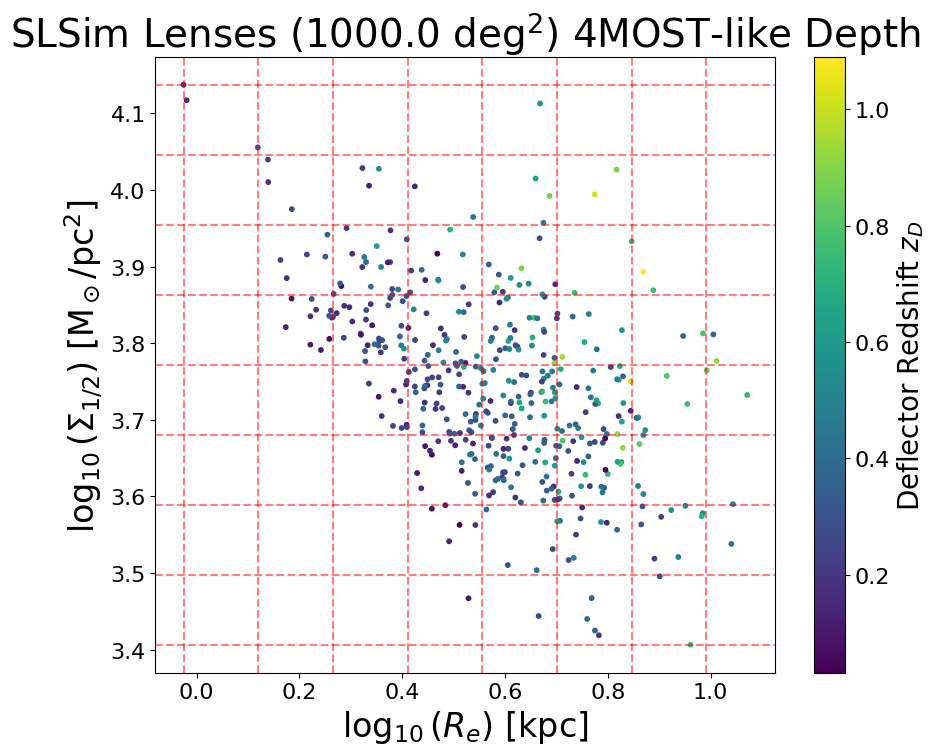

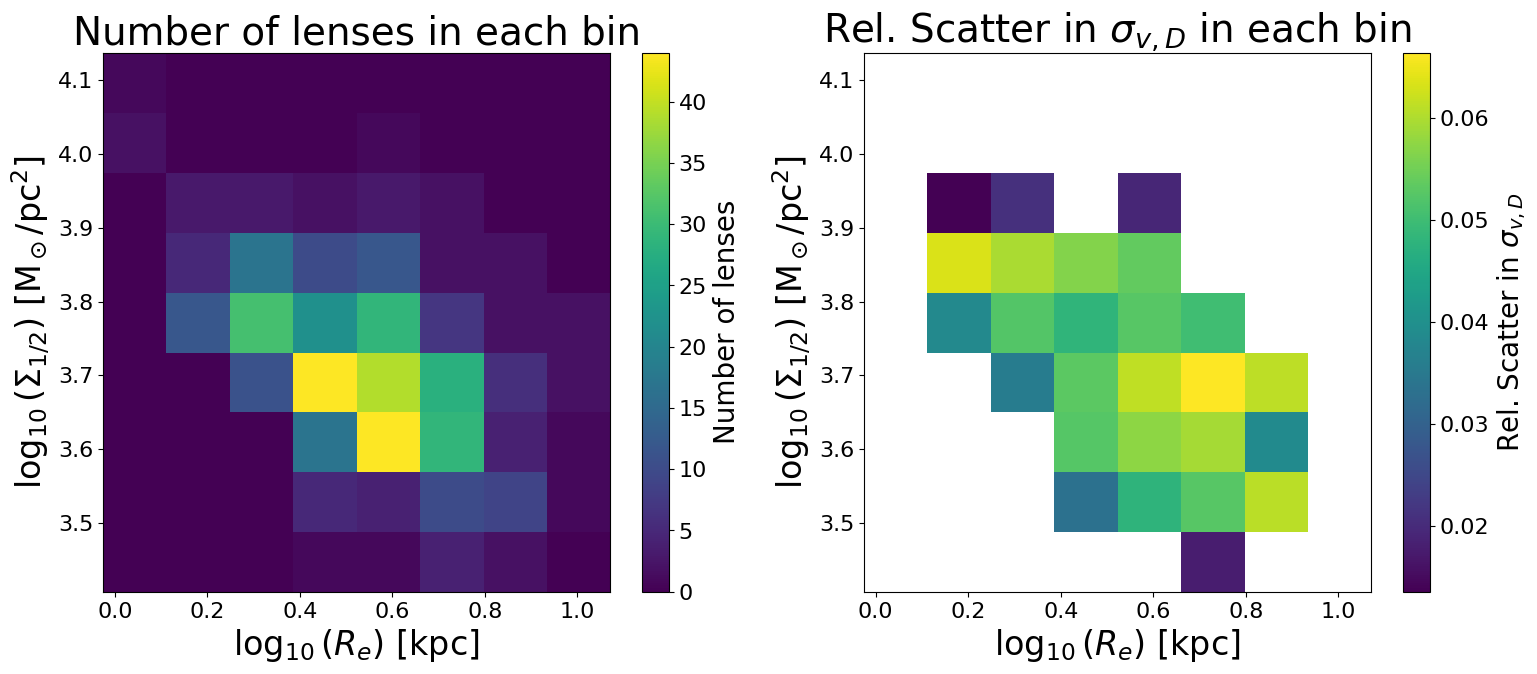

In [61]:
# for 4MOST data show the binning in R_e vs Sigma_half plane

data = lsst_4MOST_GGL_table_unique_deflectors.copy()

plt.figure(figsize=(10, 8))
plt.scatter(
    np.log10(data["R_e_kpc"]),
    np.log10(data["Sigma_half_Msun/pc2"]),
    c=data["z_D"], s=10, label='SLSim MFP', 
    cmap='viridis'
)
plt.xlabel(r'$\log_{10}(R_e)$ [kpc]', fontsize=24)
plt.ylabel(r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', fontsize=24)
plt.title(f'SLSim Lenses ({sky_area} deg$^2$) 4MOST-like Depth', fontsize=28)
cbar = plt.colorbar()
cbar.set_label('Deflector Redshift $z_D$', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.xlim(0, 1.5)
# plt.ylim(0, 4)


# Bin the data and find pairs
x = np.log10(data["R_e_kpc"])
y = np.log10(data["Sigma_half_Msun/pc2"])

# remove infinite and NaN values
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]
data = data[mask]

# determine the bin_widths based on the data's stddev
x_std = np.nanstd(x)
y_std = np.nanstd(y)
x_width_bin = 3.5 * x_std / (len(x)**(1/(2+2))) # Scott's rule
y_width_bin = 3.5 * y_std / (len(y)**(1/(2+2))) # Scott's rule
num_bins_x = int((np.nanmax(x) - np.nanmin(x)) / x_width_bin) + 1
num_bins_y = int((np.nanmax(y) - np.nanmin(y)) / y_width_bin) + 1

### draw the bins over the scatter plot
for i in range(num_bins_x):
    plt.axvline(np.nanmin(x) + i * x_width_bin, color='red', linestyle='--', alpha=0.5)
for j in range(num_bins_y):
    plt.axhline(np.nanmin(y) + j * y_width_bin, color='red', linestyle='--', alpha=0.5)


# for each bin compute scatter in sigma_v
scatter_sigma_v_bins_MFP = np.zeros((num_bins_x, num_bins_y))
num_lenses_bins_MFP = np.zeros((num_bins_x, num_bins_y))

for i in range(num_bins_x):
    for j in range(num_bins_y):
        # find the lenses in the bin
        mask_bin = (x >= np.nanmin(x) + i * x_width_bin) & (x < np.nanmin(x) + (i+1) * x_width_bin) & \
                   (y >= np.nanmin(y) + j * y_width_bin) & (y < np.nanmin(y) + (j+1) * y_width_bin)
        data_bin = data[mask_bin]
        num_lenses_bins_MFP[i, j] = len(data_bin)
        if len(data_bin) > 2:
            scatter_sigma_v_bins_MFP[i, j] = np.std(np.log10(data_bin["sigma_v_D"])) * np.log(10)
        else:
            scatter_sigma_v_bins_MFP[i, j] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# two subplots side by side
# one with number of lenses in each bin
# one with scatter in sigma_v in each bin

im1 = ax[0].imshow(num_lenses_bins_MFP.T, origin='lower',
                   extent=[np.nanmin(x), np.nanmax(x), np.nanmin(y), np.nanmax(y)],
                   aspect='auto', cmap='viridis')
ax[0].set_xlabel(r'$\log_{10}(R_e)$ [kpc]', fontsize=24)
ax[0].set_ylabel(r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', fontsize=24)
ax[0].set_title('Number of lenses in each bin', fontsize=28)
cbar1 = plt.colorbar(im1, ax=ax[0])
cbar1.set_label('Number of lenses', fontsize=20)
cbar1.ax.tick_params(labelsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=16)
im2 = ax[1].imshow(scatter_sigma_v_bins_MFP.T, origin='lower',
                   extent=[np.nanmin(x), np.nanmax(x), np.nanmin(y), np.nanmax(y)],
                   aspect='auto', cmap='viridis')
ax[1].set_xlabel(r'$\log_{10}(R_e)$ [kpc]', fontsize=24)
ax[1].set_ylabel(r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', fontsize=24)
ax[1].set_title(r'Rel. Scatter in $\sigma_{v, D}$ in each bin', fontsize=28)
cbar2 = plt.colorbar(im2, ax=ax[1])
cbar2.set_label(r'Rel. Scatter in $\sigma_{v, D}$', fontsize=20)
cbar2.ax.tick_params(labelsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)

print("Mean scatter in sigma_v bins (MFP):", np.nanmean(scatter_sigma_v_bins_MFP))

Mean scatter in sigma_v bins (MFP): 0.012008830946934435


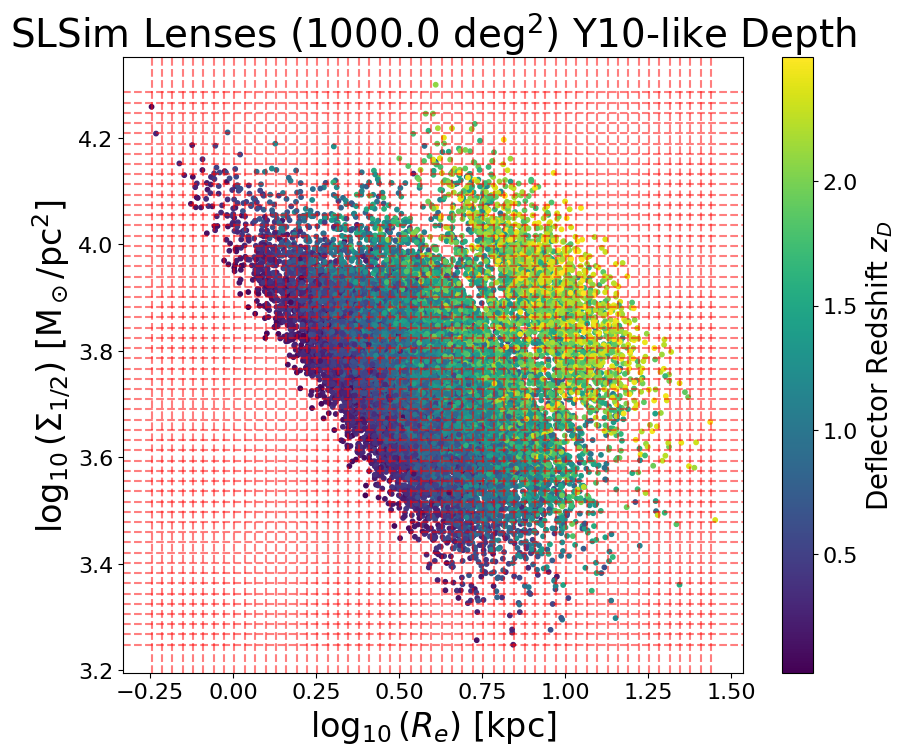

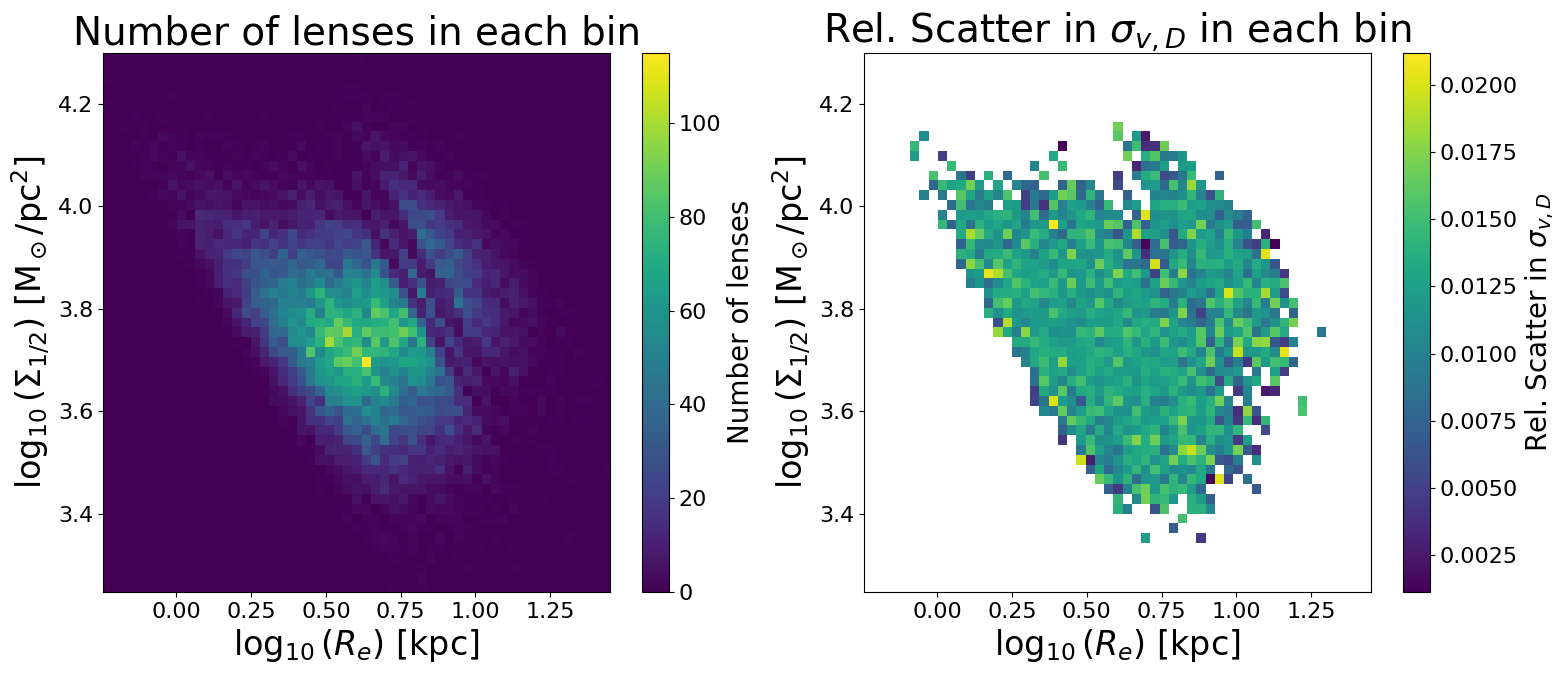

In [62]:
# for 10yr data show the binning in R_e vs Sigma_half plane

data = lsst_10_yr_GGL_table_unique_deflectors.copy()

plt.figure(figsize=(10, 8))
plt.scatter(
    np.log10(data["R_e_kpc"]),
    np.log10(data["Sigma_half_Msun/pc2"]),
    c=data["z_D"], s=10, label='SLSim MFP', 
    cmap='viridis'
)
plt.xlabel(r'$\log_{10}(R_e)$ [kpc]', fontsize=24)
plt.ylabel(r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', fontsize=24)
plt.title(f'SLSim Lenses ({sky_area} deg$^2$) Y10-like Depth', fontsize=28)
cbar = plt.colorbar()
cbar.set_label('Deflector Redshift $z_D$', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.xlim(0, 1.5)
# plt.ylim(0, 4)


# Bin the data and find pairs
x = np.log10(data["R_e_kpc"])
y = np.log10(data["Sigma_half_Msun/pc2"])

# remove infinite and NaN values
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]
data = data[mask]

# determine the bin_widths based on the data's stddev
x_std = np.nanstd(x)
y_std = np.nanstd(y)
x_width_bin = 0.5*3.5 * x_std / (len(x)**(1/(2+2))) # Scott's rule
y_width_bin = 0.5*3.5 * y_std / (len(y)**(1/(2+2))) # Scott's rule
num_bins_x = int((np.nanmax(x) - np.nanmin(x)) / x_width_bin) + 1
num_bins_y = int((np.nanmax(y) - np.nanmin(y)) / y_width_bin) + 1

### draw the bins over the scatter plot
for i in range(num_bins_x):
    plt.axvline(np.nanmin(x) + i * x_width_bin, color='red', linestyle='--', alpha=0.5)
for j in range(num_bins_y):
    plt.axhline(np.nanmin(y) + j * y_width_bin, color='red', linestyle='--', alpha=0.5)

# for each bin compute scatter in sigma_v
scatter_sigma_v_bins_MFP = np.zeros((num_bins_x, num_bins_y))
num_lenses_bins_MFP = np.zeros((num_bins_x, num_bins_y))

for i in range(num_bins_x):
    for j in range(num_bins_y):
        # find the lenses in the bin
        mask_bin = (x >= np.nanmin(x) + i * x_width_bin) & (x < np.nanmin(x) + (i+1) * x_width_bin) & \
                   (y >= np.nanmin(y) + j * y_width_bin) & (y < np.nanmin(y) + (j+1) * y_width_bin)
        data_bin = data[mask_bin]
        num_lenses_bins_MFP[i, j] = len(data_bin)
        if len(data_bin) > 2:
            scatter_sigma_v_bins_MFP[i, j] = np.std(np.log10(data_bin["sigma_v_D"])) * np.log(10)
        else:
            scatter_sigma_v_bins_MFP[i, j] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# two subplots side by side
# one with number of lenses in each bin
# one with scatter in sigma_v in each bin

im1 = ax[0].imshow(num_lenses_bins_MFP.T, origin='lower',
                   extent=[np.nanmin(x), np.nanmax(x), np.nanmin(y), np.nanmax(y)],
                   aspect='auto', cmap='viridis')
ax[0].set_xlabel(r'$\log_{10}(R_e)$ [kpc]', fontsize=24)
ax[0].set_ylabel(r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', fontsize=24)
ax[0].set_title('Number of lenses in each bin', fontsize=28)
cbar1 = plt.colorbar(im1, ax=ax[0])
cbar1.set_label('Number of lenses', fontsize=20)
cbar1.ax.tick_params(labelsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=16)
im2 = ax[1].imshow(scatter_sigma_v_bins_MFP.T, origin='lower',
                   extent=[np.nanmin(x), np.nanmax(x), np.nanmin(y), np.nanmax(y)],
                   aspect='auto', cmap='viridis')
ax[1].set_xlabel(r'$\log_{10}(R_e)$ [kpc]', fontsize=24)
ax[1].set_ylabel(r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', fontsize=24)
ax[1].set_title(r'Rel. Scatter in $\sigma_{v, D}$ in each bin', fontsize=28)
cbar2 = plt.colorbar(im2, ax=ax[1])
cbar2.set_label(r'Rel. Scatter in $\sigma_{v, D}$', fontsize=20)
cbar2.ax.tick_params(labelsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)

print("Mean scatter in sigma_v bins (MFP):", np.nanmean(scatter_sigma_v_bins_MFP))

In [63]:
# fit MFP

coeffs_MFP = fit_plane(
    np.log10(lsst_4MOST_GGL_table_unique_deflectors["R_e_kpc"]),
    np.log10(lsst_4MOST_GGL_table_unique_deflectors["Sigma_half_Msun/pc2"]),
    np.log10(lsst_4MOST_GGL_table_unique_deflectors["sigma_v_D"])
)

scatter_MFP = find_scatter(
    np.log10(lsst_4MOST_GGL_table_unique_deflectors["R_e_kpc"]),
    np.log10(lsst_4MOST_GGL_table_unique_deflectors["Sigma_half_Msun/pc2"]),
    np.log10(lsst_4MOST_GGL_table_unique_deflectors["sigma_v_D"]),
    coeffs_MFP,
    return_fit=False
)

print("4MOST-like Depth MFP scatter:", np.std(scatter_MFP) * np.log(10) * 100, "%")

4MOST-like Depth MFP scatter: 0.45658195720710015 %


Mean scatter in sigma_v bins (MFP): 0.007027167936474389


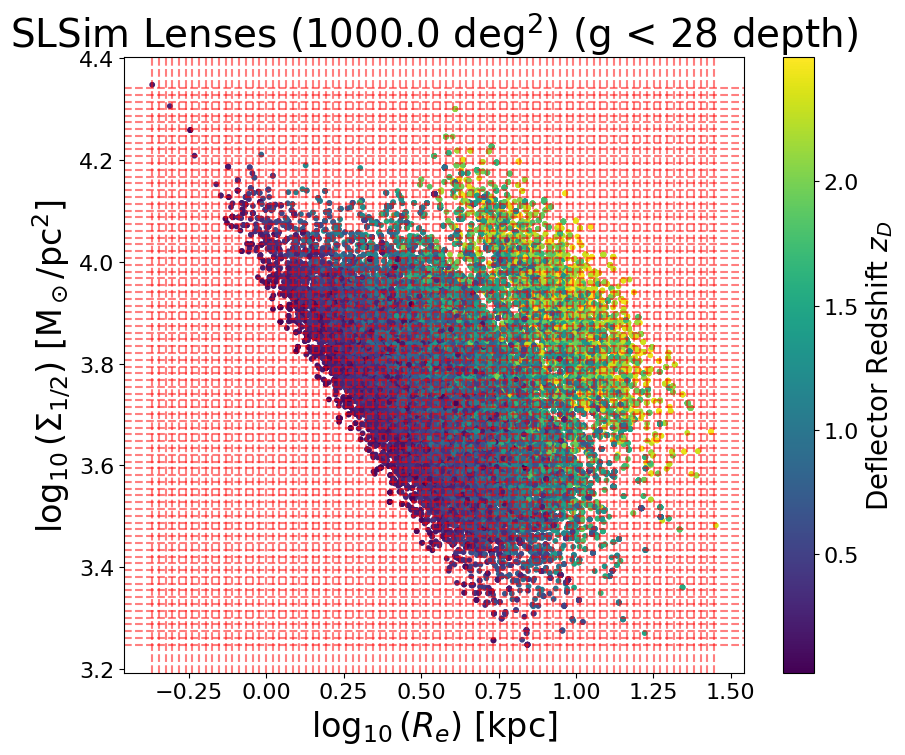

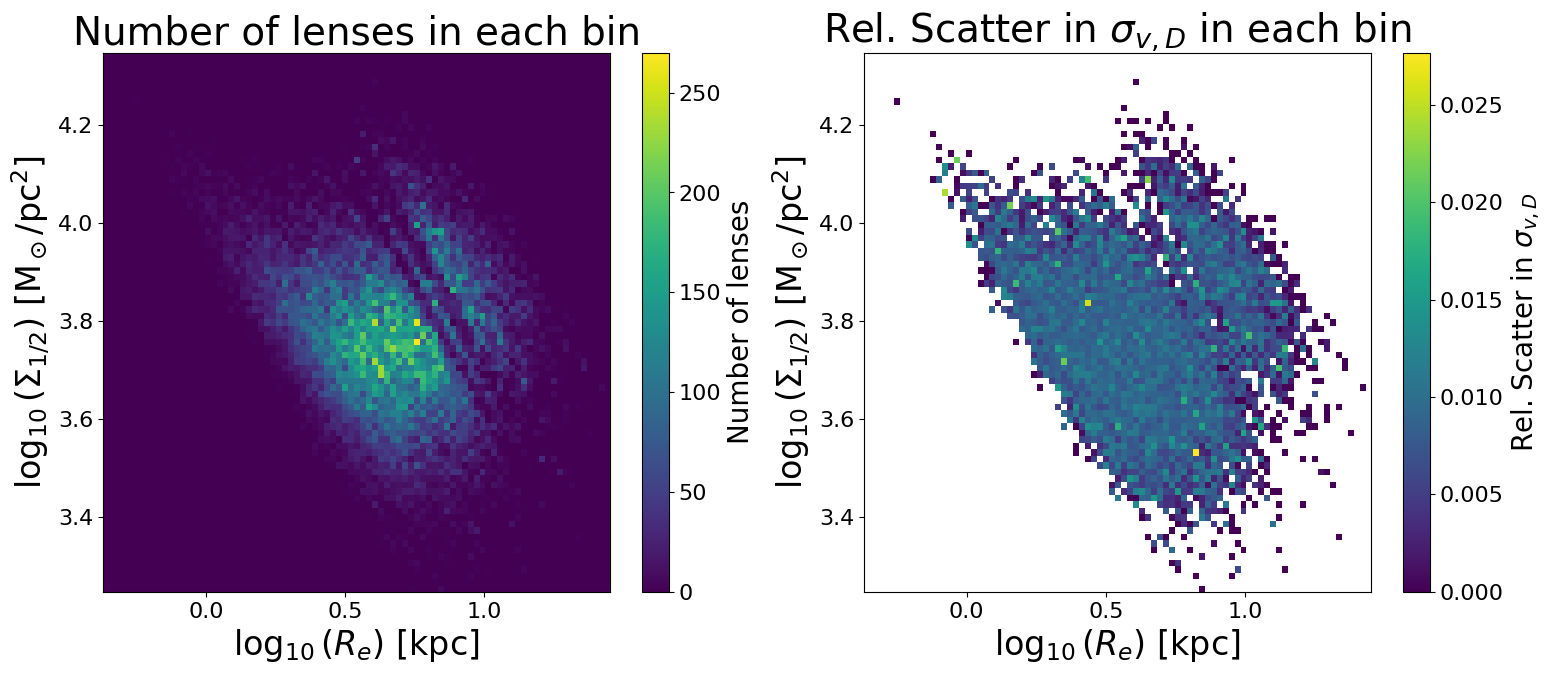

In [64]:
# for full data show the binning in R_e vs Sigma_half plane

data = GGL_data_table.copy()

plt.figure(figsize=(10, 8))
plt.scatter(
    np.log10(data["R_e_kpc"]),
    np.log10(data["Sigma_half_Msun/pc2"]),
    c=data["z_D"], s=10, label='SLSim MFP', 
    cmap='viridis'
)
plt.xlabel(r'$\log_{10}(R_e)$ [kpc]', fontsize=24)
plt.ylabel(r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', fontsize=24)
plt.title(f'SLSim Lenses ({sky_area} deg$^2$) (g < 28 depth)', fontsize=28)
cbar = plt.colorbar()
cbar.set_label('Deflector Redshift $z_D$', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.xlim(0, 1.5)
# plt.ylim(0, 4)


# Bin the data and find pairs
x = np.log10(data["R_e_kpc"])
y = np.log10(data["Sigma_half_Msun/pc2"])

# remove infinite and NaN values
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]
data = data[mask]

# determine the bin_widths based on the data's stddev
x_std = np.nanstd(x)
y_std = np.nanstd(y)
x_width_bin = 0.5*3.5 * x_std / (len(x)**(1/(2+2))) # Scott's rule
y_width_bin = 0.5*3.5 * y_std / (len(y)**(1/(2+2))) # Scott's rule
num_bins_x = int((np.nanmax(x) - np.nanmin(x)) / x_width_bin) + 1
num_bins_y = int((np.nanmax(y) - np.nanmin(y)) / y_width_bin) + 1

### draw the bins over the scatter plot
for i in range(num_bins_x):
    plt.axvline(np.nanmin(x) + i * x_width_bin, color='red', linestyle='--', alpha=0.5)
for j in range(num_bins_y):
    plt.axhline(np.nanmin(y) + j * y_width_bin, color='red', linestyle='--', alpha=0.5)

# for each bin compute scatter in sigma_v
scatter_sigma_v_bins_MFP = np.zeros((num_bins_x, num_bins_y))
num_lenses_bins_MFP = np.zeros((num_bins_x, num_bins_y))

for i in range(num_bins_x):
    for j in range(num_bins_y):
        # find the lenses in the bin
        mask_bin = (x >= np.nanmin(x) + i * x_width_bin) & (x < np.nanmin(x) + (i+1) * x_width_bin) & \
                   (y >= np.nanmin(y) + j * y_width_bin) & (y < np.nanmin(y) + (j+1) * y_width_bin)
        data_bin = data[mask_bin]
        num_lenses_bins_MFP[i, j] = len(data_bin)
        if len(data_bin) > 2:
            scatter_sigma_v_bins_MFP[i, j] = np.std(np.log10(data_bin["sigma_v_D"])) * np.log(10)
        else:
            scatter_sigma_v_bins_MFP[i, j] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# two subplots side by side
# one with number of lenses in each bin
# one with scatter in sigma_v in each bin

im1 = ax[0].imshow(num_lenses_bins_MFP.T, origin='lower',
                   extent=[np.nanmin(x), np.nanmax(x), np.nanmin(y), np.nanmax(y)],
                   aspect='auto', cmap='viridis')
ax[0].set_xlabel(r'$\log_{10}(R_e)$ [kpc]', fontsize=24)
ax[0].set_ylabel(r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', fontsize=24)
ax[0].set_title('Number of lenses in each bin', fontsize=28)
cbar1 = plt.colorbar(im1, ax=ax[0])
cbar1.set_label('Number of lenses', fontsize=20)
cbar1.ax.tick_params(labelsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=16)
im2 = ax[1].imshow(scatter_sigma_v_bins_MFP.T, origin='lower',
                   extent=[np.nanmin(x), np.nanmax(x), np.nanmin(y), np.nanmax(y)],
                   aspect='auto', cmap='viridis')
ax[1].set_xlabel(r'$\log_{10}(R_e)$ [kpc]', fontsize=24)
ax[1].set_ylabel(r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', fontsize=24)
ax[1].set_title(r'Rel. Scatter in $\sigma_{v, D}$ in each bin', fontsize=28)
cbar2 = plt.colorbar(im2, ax=ax[1])
cbar2.set_label(r'Rel. Scatter in $\sigma_{v, D}$', fontsize=20)
cbar2.ax.tick_params(labelsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)

print("Mean scatter in sigma_v bins (MFP):", np.nanmean(scatter_sigma_v_bins_MFP))